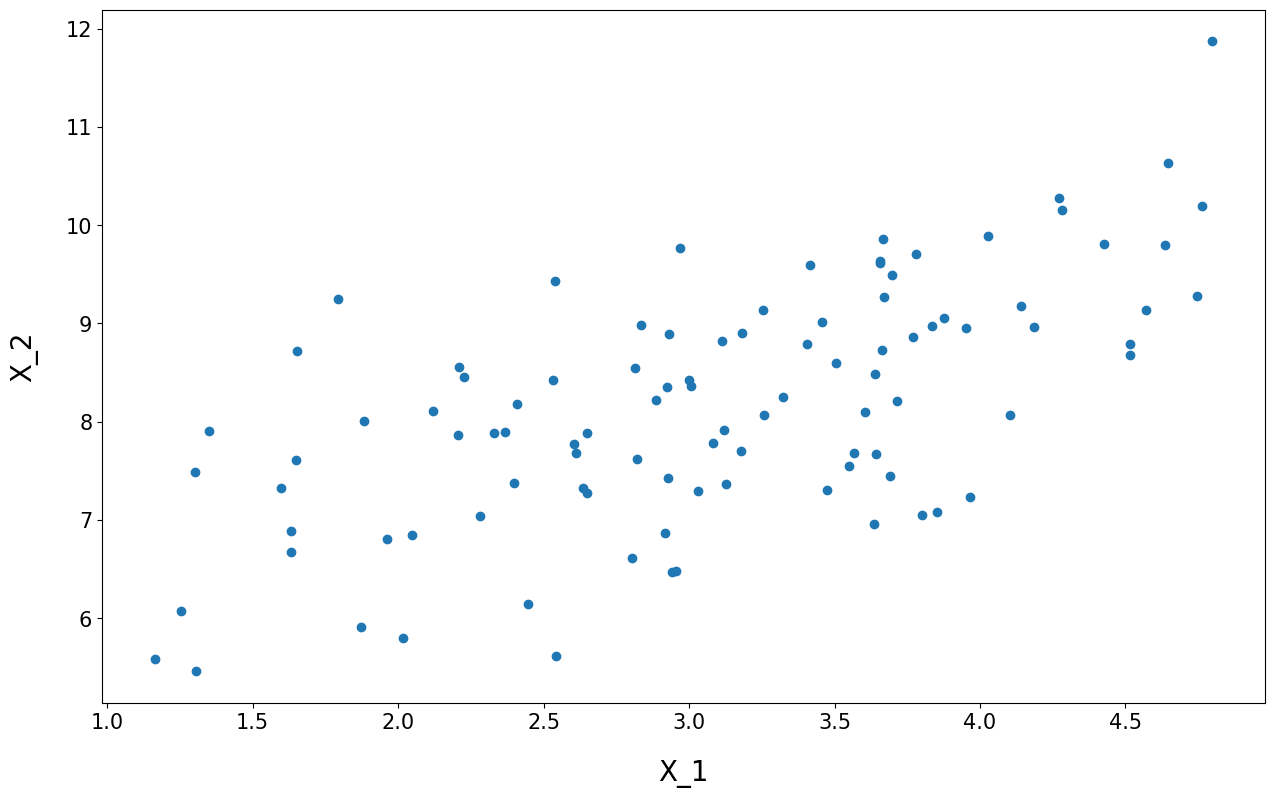

In [312]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as st

n = 100
mu = np.array([3,8])
sigma = np.array([[1,1],
                  [1,2]])

data = st.multivariate_normal.rvs(mu, sigma, size=n, random_state=42)

X_1, X_2 = data[:, 0], data[:, 1]

#  Plot
font_size = 20
label_pad = 20

plt.figure(figsize=(15, 9))
plt.grid()

plt.scatter(X_1, X_2)

plt.xlabel('X_1', fontsize=font_size, labelpad=label_pad)
plt.ylabel('X_2', fontsize=font_size, labelpad=label_pad)

plt.xticks(fontsize=0.75*font_size)
plt.yticks(fontsize=0.75*font_size)

plt.grid()
plt.show()

In [301]:
mu_hat = data.mean(axis=0)
sigma_hat = np.cov(data, rowvar=False)

s = np.sqrt(1/(n-1) * np.sum((data - mu_hat)**2, axis=0))

rho = 1/np.sqrt(2)

rho_hat = np.mean( np.prod(data-mu_hat, axis=1) ) / np.prod(s)
rho_hat

0.6274465233930543

In [302]:
# Fisher CI
alpha = 0.05
z_alpha2 = st.norm.ppf(1-alpha/2)

se_hat = 1/np.sqrt(n-3)

# theta = f(rho_hat)
theta_hat = 1/2 * (np.log(1+rho_hat) - np.log(1-rho_hat))

# CI (a,b) for theta
ci_theta = np.array([theta_hat - z_alpha2*se_hat, theta_hat + z_alpha2*se_hat])

# CI for f^-1 or rho
ci_rho = (np.exp(2*ci_theta) - 1) / (np.exp(2*ci_theta) + 1)
print(ci_rho)

[0.49161609 0.73347038]


In [303]:
def rho_bootstrap(rep: int):
    data_rep = st.multivariate_normal.rvs(mu, sigma, size=n, random_state=rep)

    B = 1_000
    rhos = np.empty(B)
    for i in range(B):
        rng = np.random.default_rng(i)
        data_B = rng.choice(data_rep, size=n, replace=True)
        
        mu_B = data_B.mean(axis=0)

        s_B = np.sqrt(1/(n-1) * np.sum((data_B - mu_B)**2, axis=0))

        rhos[i] = np.mean( np.prod(data_B-mu_B, axis=1) ) / np.prod(s_B)

    return np.quantile(rhos, alpha/2), np.quantile(rhos, 1-alpha/2)

In [304]:
def rho_bootstrap_2(rep: int):
    data_rep = st.multivariate_normal.rvs(mu, sigma, size=n, random_state=rep)
    
    B = 1000
    rng = np.random.default_rng(rep)
    idx = rng.choice(range(n), size=(B, n), replace=True)
    data_B = np.empty((n, 2, B))

    for i in range(B):
        data_B[:, :, i] = data_rep[idx[i, :], :]

    mu_B: np.ndarray = data_B.mean(axis=0)
    s_B: np.ndarray = np.sqrt(1/(n-1) * np.sum((data_B - mu_B)**2, axis=0))
    rho_B = np.mean( np.prod(data_B-mu_B, axis=1), axis=0 ) / np.prod(s_B, axis=0)
    
    return np.quantile(rho_B, alpha/2), np.quantile(rho_B, 1-alpha/2)

In [305]:
def ci_fisher(rho_f: float):
    # theta = f(rho_hat)
    theta = 1/2 * (np.log(1+rho_f) - np.log(1-rho_f))

    # CI (a,b) for theta
    ci = np.array([theta - z_alpha2*se_hat, theta + z_alpha2*se_hat])

    # CI for f^-1 or rho
    return (np.exp(2*ci) - 1) / (np.exp(2*ci) + 1)

In [306]:
def i_sum(A: np.ndarray):
    return np.einsum('ijk->jk', A)

def rho_fisher(X: np.ndarray):
    mu_f = X.mean(axis=0)

    s_f = np.sqrt(1/(n-1) * np.sum((X - mu_f)**2, axis=0))

    return np.mean( np.prod(X-mu_f, axis=1) ) / np.prod(s_f)

def rho_corr(X: np.ndarray):
    X_mu = X - 1/n * i_sum(X)
    s: np.ndarray = np.sqrt(1/(n-1) * i_sum(np.einsum('ijk,ijk->ijk', X_mu, X_mu)))
    return 1/n * np.einsum( 'ij->j', np.prod(X_mu, axis=1) ) / np.prod(s, axis=0)

In [307]:
def rho_bootstrap_3(rep: int) -> tuple:
    data_rep = st.multivariate_normal.rvs(mu, sigma, size=n, random_state=rep)
    rho_f = rho_fisher(data_rep)
    
    B = 1000
    rng = np.random.default_rng(rep)
    idx = rng.choice(range(n), size=(B, n), replace=True)
    data_B = np.empty((n, 2, B))

    for i in range(B):
        data_B[:, :, i] = data_rep[idx[i, :], :]

    rho_B = rho_corr(data_B)
    
    return ci_fisher(rho_f), (np.quantile(rho_B, alpha/2), np.quantile(rho_B, 1-alpha/2))

In [308]:
from tqdm.notebook import tqdm

reps = 1_000

count_fisher = 0
count_bootstrap = 0

for rep in tqdm(range(reps)):
    ci_fish, ci_bootstrap = rho_bootstrap_3(rep)

    if ci_fish[0] <= rho <= ci_fish[1]:
        count_fisher += 1

    if ci_bootstrap[0] <= rho <= ci_bootstrap[1]:
        count_bootstrap += 1

print(count_fisher, count_bootstrap)

  0%|          | 0/1000 [00:00<?, ?it/s]

953 938


In [309]:
%reset -f